# [Computational Social Science] Project 4: Unsupervised Learning

Group number: 7
Group members: Alonzo Ackerman; Ernesto Gutiérrez Topete; Valentín Sierra
Semester: Fall 2021

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [2]:
# Load nhanes data
nhanes = pd.read_csv('data/nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN and HSD010 from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

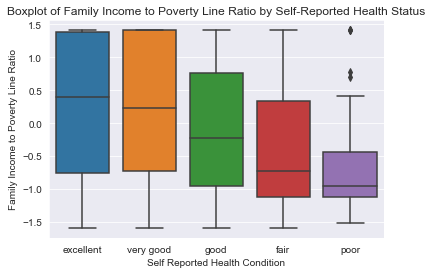

In [3]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

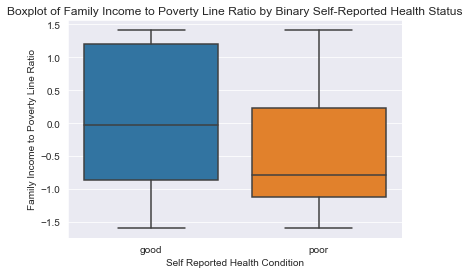

In [4]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

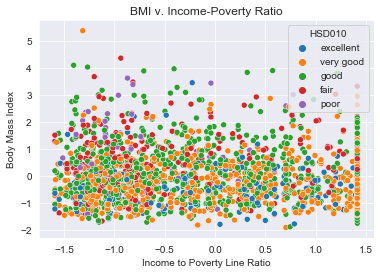

In [5]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [6]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components.
- Plot a barplot of the variation explains by each component.
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

We train our PCA and fit it with 20 components. Given that in our data set with have 240+, PCA will allow us with dimensionality reduction. 20 is a good number with which we hope to find a considerable percentage of variability explained. This number of components is also easier to visualize.

In [7]:
pca = PCA(n_components=20)
principalComponents_nhanes = pca.fit_transform(nhanes_scaled)

### Barplot of Components

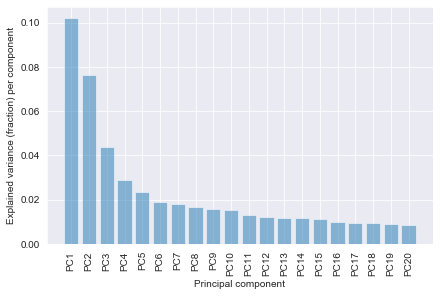

In [8]:
## Your Answer Here
from psynlig import pca_explained_variance_bar
pca_explained_variance_bar(pca, alpha=0.5)

plt.show()



Text(0, 0.5, 'cumulative explained variance')

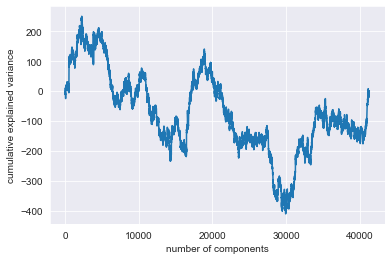

In [9]:
plt.plot(np.cumsum(pca.fit_transform(nhanes_scaled)))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

### How many components will you use to fit a supervised learning model?

As we can see from the percentage of explained variace in the first graph, approximately 40% of the variance can be explained with the first 15 components.  


### 2D Scatterplot of the first two components

In [10]:
nhanes_scaledlabels=nhanes_scaled.copy()
nhanes_scaledlabels['HSD010_binary'] = hsd010_binary

In [11]:
pca_df = pd.DataFrame(data = principalComponents_nhanes, 
                      columns = [('principal component ' + str(i)) for i in range(1,pca.n_components+1)])
pca_df.head(4)

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,principal component 11,principal component 12,principal component 13,principal component 14,principal component 15,principal component 16,principal component 17,principal component 18,principal component 19,principal component 20
0,9.527811,-0.816224,-1.867092,-2.109929,-3.929417,-0.185059,-3.845004,-2.935284,1.515443,0.681290,0.119156,2.240655,0.289609,-0.652046,0.353855,-0.661971,0.305689,0.380861,-0.882430,2.479316
1,-5.838339,-3.692573,3.805750,-1.029663,0.394457,1.593884,2.711254,-0.740362,0.383484,-2.405477,-0.446440,1.110764,0.581679,2.430035,0.203283,-1.468934,0.525823,-1.263595,-1.604866,2.583354
2,-0.719454,-2.573200,0.907904,-4.755847,-1.798904,0.863709,-1.024402,0.633915,0.543976,0.448167,0.161933,-1.326358,1.692561,-0.284933,0.478060,-0.710312,-0.101363,-0.506326,-0.093578,3.288533
3,3.533627,-2.576982,-3.249126,-0.405446,3.998876,1.444574,-1.181964,0.325658,-4.152700,-1.248847,-0.767814,2.077444,-2.288244,2.874828,-1.257265,-1.274746,1.242279,0.586361,0.129368,-0.686101


<Figure size 432x288 with 0 Axes>

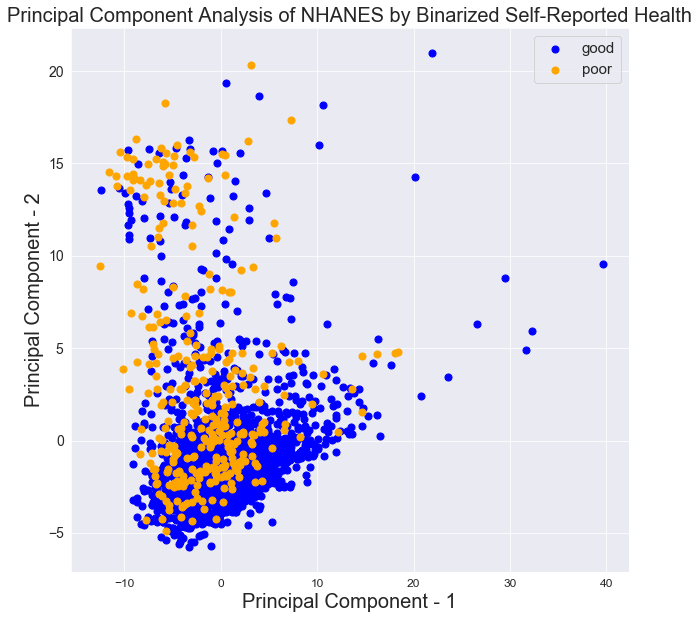

In [12]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of NHANES by Binarized Self-Reported Health",fontsize=20)
targets = ['good', 'poor']
colors = ['b', 'orange']

for target, color in zip(targets,colors):
    indicesToKeep = nhanes_scaledlabels['HSD010_binary'] == target
    plt.scatter(pca_df.loc[indicesToKeep.reset_index(drop = True), 'principal component 1']
               , pca_df.loc[indicesToKeep.reset_index(drop = True), 'principal component 2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})
plt.show()

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

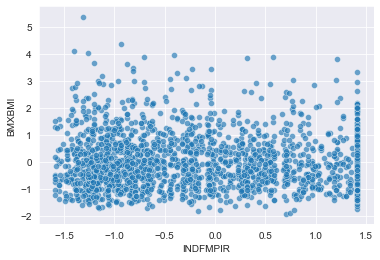

In [13]:
# exploratory visualization

# visualize data distribution for BMI by income-poverty ratio
ax = sns.scatterplot(data=nhanes_scaled, x="INDFMPIR", y="BMXBMI", palette="tab10", alpha=0.65)

As we can see in the exploratory graph above, there isn't a predictable distribution of the data that may indicate how many clusters there are or if clusters are _weirdly_ shaped. Accordingly, we chose the k-means clustering method because:
- it is easy to implement
- it is more computationally efficient when working with several variables (>240)
- there is no need to accommodate geometrically-complex clusters

### Cluster nhanes

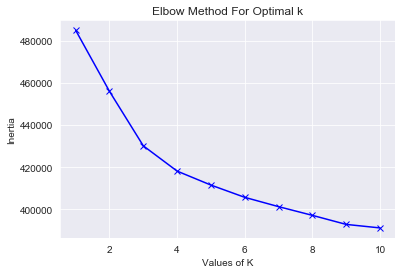

In [14]:
# set the seed
np.random.seed(10)

# create an elbow method graph to assess inertia value per k (1-10)
sum_of_squared_distances = []
K = range(1,11)

# obtain inertia values
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(nhanes_scaled)
    sum_of_squared_distances.append(kmeans.inertia_)

# plot the inertia values for each k
plt.plot(K,sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

We chose 3 as the number of clusters to use because it is the parameter value that came closest to an inflection point in the graph of inertia values. After this point, complexity contributes very little to the sum of squared distances to the centroids (or inertia).

In [15]:
#train k-means model with 3 clusters on entire dataset
kmeans = KMeans(n_clusters=3, max_iter=300).fit(nhanes_scaled)

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

In [16]:
# create df with variables of interest (Income, BMI, cluster category)
bmi_income_df = nhanes_scaled[["INDFMPIR", "BMXBMI"]].copy()
bmi_income_df["LABELS"] = kmeans.labels_
bmi_income_df

,INDFMPIR,BMXBMI,LABELS
SEQN,,,
73568,1.412214,-1.001972,2
73576,-0.642017,-0.618783,1
73579,0.192890,-1.636215,1
73581,1.412214,-0.565929,2
73584,0.252955,-0.341301,1
...,...,...,...
83694,0.343053,-0.341301,2
83696,-1.092507,0.081527,1
83704,-1.591048,1.508575,1


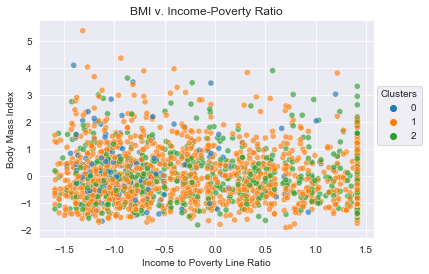

In [17]:
# plot cluster categories for Income and BMI variables
ax = sns.scatterplot(data=bmi_income_df, x="INDFMPIR", y="BMXBMI", hue="LABELS", palette="tab10", alpha=0.65)

plt.xlabel("Income to Poverty Line Ratio")
plt.ylabel("Body Mass Index")
plt.title("BMI v. Income-Poverty Ratio")
plt.legend(title="Clusters", 
           bbox_to_anchor=(1.01, 0.7), 
           borderaxespad=0)

plt.show()

The BMI-Income ratio plot above shows that there's no clear distribution of the three categories obtained from the entire dataset. This indicates that Income to Poverty ratio and BMI are not strongly correlated with the groups obtained through the k-means clustering method.

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [18]:
#train k-means model with 3 clusters on principal component dataset
kmeans_pca = KMeans(n_clusters=3, max_iter=300).fit(pca_df)

In [19]:
# create df with variables of interest (Income, BMI, cluster category)
pca_cluster_df = pca_df[["principal component 1", "principal component 2"]].copy()
pca_cluster_df["LABELS"] = kmeans_pca.labels_
pca_cluster_df

,principal component 1,principal component 2,LABELS
0,9.527811,-0.816224,1
1,-5.838339,-3.692573,0
2,-0.719454,-2.573200,0
3,3.533627,-2.576982,1
4,-6.872094,-4.194241,0
...,...,...,...
2059,2.643319,-1.689356,1
2060,1.037906,-0.118065,0
2061,1.130253,-0.970432,0
2062,7.145093,-0.376752,1


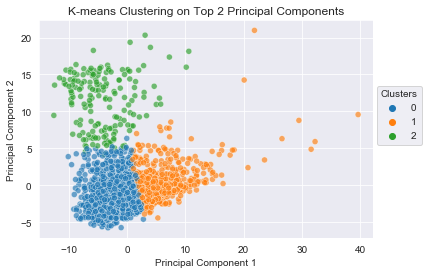

In [20]:
# create df with variables of interest (Income, BMI, cluster category)
ax = sns.scatterplot(data=pca_cluster_df, x="principal component 1", y="principal component 2", 
                     hue="LABELS", palette="tab10", alpha=0.65)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-means Clustering on Top 2 Principal Components")
plt.legend(title="Clusters", 
           bbox_to_anchor=(1.01, 0.7), 
           borderaxespad=0)

plt.show()

The nearly surgical precision of the groups in the plot above shows that the first two principal components are more strongly correlated with the clusters obtained through the k-means method on the components from the pca model.

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [ ]:
y = ... # either hsd010 or hsd010_binary
X = ... # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

In [ ]:
import keras
num_classes = ...
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(..., ...)
y_test = keras.utils.to_categorical(..., ...)
num_classes = y_test.shape[1]

In [ ]:
model = Sequential()

model.add(
    Dense(..., input_dim= ..., kernel_initializer= ..., activation= ...)
)

model.add(
    Dense(..., kernel_initializer= ..., activation= ...)
)

## Add any additional layers you wish here

model.compile(loss= ..., optimizer= ..., metrics=[...])

model.fit(..., ..., validation_data=(..., ...), epochs=..., batch_size=..., verbose=...)

### Neural Network on Principal Components

In [ ]:
## Your Answer Here

### Neural Network on Principal Components + Cluster Membership

In [ ]:
## Your Answer Here

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

## Your Answer Here

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

## Your Answer Here

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

In [ ]:
## Your Answer Here